Data Source:  http://insideairbnb.com/get-the-data.html

## 1. Import Boilerplate code

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
import mpl_toolkits
from datetime import datetime
import geopandas

In [2]:
import folium
import mpl_toolkits
import nltk
import textblob

In [3]:
pd.set_option('display.max_columns', None)

## 2. Import Data and review the top 5 fields

In [4]:
data_folder='../../data/airbnb/'
#files: calendar.csv.gz  listings_summary.csv    reviews.csv.gz
# listings.csv     neighbourhoods.csv      reviews_summary.csv
# listings.csv.gz  neighbourhoods.geojson

data_calendar = pd.read_csv(data_folder+"calendar.csv")
data_listings_summary=pd.read_csv(data_folder+"listings_summary.csv")
data_reviews = pd.read_csv(data_folder+"reviews.csv.gz")
data_listings = pd.read_csv(data_folder+"listings.csv",low_memory=False, parse_dates=True)
data_neighbourhoods= pd.read_csv(data_folder+"neighbourhoods.csv", low_memory=False)
data_review_summary=pd.read_csv(data_folder+"reviews_summary.csv")
data_neighbourhoods_geo=pd.read_json(data_folder+"neighbourhoods.geojson")

In [5]:
data_listings.neighborhood_overview.head()

0    Not even 10 minutes by metro from Victoria Sta...
1                                                  NaN
2    Finsbury Park is a friendly melting pot commun...
3    Very easy to get to all the main sites. The tu...
4    A quick guide or a run through about the area ...
Name: neighborhood_overview, dtype: object

## 3. Clean Data
- Remove non-GB based listings
- Remove listings with per day price is greater than £x.00 i.e. any artificial skews in the data
- Remove listings with price, bed etc set as £0
- Remove listings where reviews are in a non-english language

In [6]:
data_listings[data_listings.country_code!="GB"].head()

id                            listing_url       scrape_id  \
41783  23325697  https://www.airbnb.com/rooms/23325697  20191105115249   
57006  30320965  https://www.airbnb.com/rooms/30320965  20191105115249   
61178  32394504  https://www.airbnb.com/rooms/32394504  20191105115249   

      last_scraped                                               name  \
41783   2019-11-06                                         Can torres   
57006   2019-11-05  Chambre idéal pour couple, 10min à pied de Camden   
61178   2019-11-06            Cosy one bedroom , near station Edgware   

                                                 summary  \
41783                           M7 minutes to Ibiza Town   
57006  Chambre lumineuse très bien situé à 7min à pie...   
61178                                                NaN   

                                                   space  \
41783                                                NaN   
57006  L’appartement est calme et très bien situé pou...   
61178                                                NaN   

                                             description experiences_offered  \
41783                           M7 minutes to Ibiza Town                none   
57006  Chambre lumineuse très bien situé à 7min à pie...                none   
61178                                                NaN                none   

                                   neighborhood_overview notes transit  \
41783                                                NaN   NaN     NaN   
57006  Vous trouverez une station de métro (Kentish T...   NaN     NaN   
61178                                                NaN   NaN     NaN   

                                                  access  \
41783                                                NaN   
57006  Vous disposerez en plus de la chambre d’une cu...   
61178                                                NaN   

                                             interaction  \
41783                                                NaN   
57006  Je suis disponible par sms ou téléphone dès qu...   
61178                                                NaN   

                                             house_rules  thumbnail_url  \
41783                                                NaN            NaN   
57006  Entretenir la chambre et les pièces communes a...            NaN   
61178                                                NaN            NaN   

       medium_url                                        picture_url  \
41783         NaN  https://a0.muscache.com/im/pictures/b8eef05a-1...   
57006         NaN  https://a0.muscache.com/im/pictures/feb1380b-e...   
61178         NaN  https://a0.muscache.com/im/pictures/3f63d61b-f...   

       xl_picture_url    host_id                                     host_url  \
41783             NaN   85507414   https://www.airbnb.com/users/show/85507414   
57006             NaN   63917372   https://www.airbnb.com/users/show/63917372   
61178             NaN  223329904  https://www.airbnb.com/users/show/223329904   

      host_name  host_since                         host_location host_about  \
41783    Lionel  2016-07-23               England, United Kingdom        NaN   
57006     Fanny  2016-03-21  Biarritz, Nouvelle-Aquitaine, France        NaN   
61178     Houda  2018-10-30       London, England, United Kingdom        NaN   

      host_response_time host_response_rate  host_acceptance_rate  \
41783                NaN                NaN                   NaN   
57006                NaN                NaN                   NaN   
61178                NaN                NaN                   NaN   

      host_is_superhost                                 host_thumbnail_url  \
41783                 f  https://a0.muscache.com/im/pictures/user/08754...   
57006                 f  https://a0.muscache.com/im/pictures/user/54f77...   
61178                 f  https://a0.muscache.com/im/pictures/user/a04e4...   

               

In [7]:
data_listings.drop(data_listings[data_listings.country_code!="GB"].index.values,axis=0,inplace=True)

### 3a. Map in numerical price from summary file

In [8]:
data_listings['price2'] = data_listings['id'].map(data_listings_summary.set_index('id')['price'])

In [9]:
data_listings.isnull().sum()[data_listings.isnull().sum()>0]

name                               25
summary                          4331
space                           25848
description                      2384
neighborhood_overview           30372
notes                           52266
transit                         30745
access                          39318
interaction                     35284
house_rules                     35805
thumbnail_url                   85065
medium_url                      85065
xl_picture_url                  85065
host_name                          12
host_since                         12
host_location                     228
host_about                      35748
host_response_time              25897
host_response_rate              25897
host_acceptance_rate            85065
host_is_superhost                  12
host_thumbnail_url                 12
host_picture_url                   12
host_neighbourhood              18743
host_listings_count                12
host_total_listings_count          12
host_has_pro

### 3b. Drop scrape_id,l isting_url,interaction,notes,thumbnail_url,medium_url,picture_url,host_url,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_thumbnail_url,host_picture_url,host_listings_count,host_verifications,host_identity_verified

In [10]:
data_listings.drop(["scrape_id","listing_url","interaction","notes","thumbnail_url","medium_url","picture_url","host_url","host_name","host_response_time","host_response_rate","host_acceptance_rate","host_thumbnail_url","host_picture_url","host_listings_count","host_verifications","host_identity_verified"],axis=1,inplace=True)
data_listings.drop(["first_review","license","jurisdiction_names","requires_license","require_guest_phone_verification"],axis=1,inplace=True)
data_listings.drop(["xl_picture_url","host_location","market","smart_location","country_code","country","is_location_exact"],axis=1,inplace=True)
data_listings.drop(["host_neighbourhood","street","square_feet","weekly_price","monthly_price","security_deposit","cleaning_fee","guests_included","review_scores_accuracy","review_scores_checkin","review_scores_communication","review_scores_value"],axis=1,inplace=True)
data_listings.drop(["neighbourhood_group_cleansed","minimum_nights_avg_ntm","maximum_nights_avg_ntm","calendar_updated","calculated_host_listings_count","calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms"],axis=1,inplace=True)
data_listings.drop(["transit","zipcode","city","state"],axis=1,inplace=True)
data_listings.drop(['maximum_nights','minimum_minimum_nights', 'maximum_minimum_nights','minimum_maximum_nights', 'maximum_maximum_nights'],axis=1,inplace=True)
data_listings.drop(["bathrooms","bedrooms","neighbourhood",'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',"is_business_travel_ready"],axis=1,inplace=True)
data_listings.drop(["has_availability","extra_people"],axis=1,inplace=True)


In [11]:
data_listings.drop(["number_of_reviews_ltm"],axis=1,inplace=True)

In [12]:
data_listings.columns

Index(['id', 'last_scraped', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'access', 'house_rules',
       'host_id', 'host_since', 'host_about', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'beds', 'bed_type', 'amenities', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'reviews_per_month', 'price2'],
      dtype='object')

### 3c. Dropping meaningful variables with null and or 0 values

In [13]:
data_listings.drop(data_listings[data_listings.beds==0].index.values,axis=0, inplace=True)

In [14]:
data_listings.drop(data_listings[data_listings.beds.isnull()].index.values,axis=0, inplace=True)

In [15]:
#data_listings.drop(data_listings[data_listings.neighbourhood.isnull()].index.values,axis=0, inplace=True)

In [16]:
data_listings.drop(data_listings[data_listings.review_scores_rating.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.review_scores_cleanliness.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.review_scores_location.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.host_is_superhost.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.host_has_profile_pic.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.property_type=="Parking Space"].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.price2==10000].index.values,inplace=True)
data_listings.drop(data_listings[data_listings.price2>250].index.values,inplace=True)
data_listings.drop(data_listings[data_listings.price2==0].index.values,inplace=True)

In [17]:
data_listings.drop(data_listings[data_listings.reviews_per_month.isnull()].index.values,axis=0, inplace=True)

### 3d. Identify the numerical, categorical and qualitative variables

In [18]:
#numeric_fields

In [19]:
# data_listings.dtypes[data_listings.dtypes!=object].index.values
# text_fields=data_listings.dtypes[data_listings.dtypes==object].index.values
# numeric_fields=data_listings.dtypes[data_listings.dtypes!=object].index.values
# np.delete(numeric_fields,[0,2],)
# data_listings[numeric_fields].describe()
# ar=np.argwhere(numeric_fields == ("price2"))
# car=np.argwhere(numeric_fields == ("price_per_guest"))
# bar=np.argwhere(numeric_fields == ("pppg_prop"))
# dar=np.argwhere(numeric_fields == ("latitude"))
# var=np.argwhere(numeric_fields == ("longitude"))
# gar=np.argwhere(numeric_fields == ("id"))
# far=np.argwhere(numeric_fields == ("host_id"))
# xar=np.argwhere(numeric_fields == ("host_is_superhost"))
# yar=np.argwhere(numeric_fields == ("host_has_profile_pic"))
# zar=np.argwhere(numeric_fields == ("require_guest_profile_picture"))
# ear=np.argwhere(numeric_fields == ("dist_lat"))
# iar=np.argwhere(numeric_fields == ("dist_long"))

# numeric_fields=np.delete(numeric_fields,[ar,bar,car,var,dar,gar,far,xar,yar,zar,ear,iar])

### 3e. Introduce price per guest variable

In [20]:
data_listings['price_per_guest']=data_listings['price2']/data_listings['accommodates']

In [21]:
data_listings.price_per_guest.max()

250.0

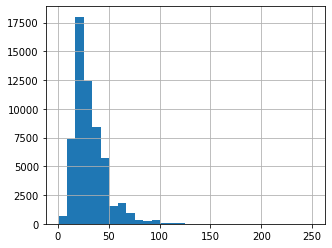

In [22]:
data_listings.price_per_guest.hist(bins=30,figsize=(5,4))

In [23]:
## Let's check for skew and kurtosis
print("Skewness before log transform: ", data_listings.price_per_guest.skew())
print("Kurtosis before log transform: ",data_listings.price_per_guest.kurt())


Skewness before log transform:  2.2195241380417405
Kurtosis before log transform:  11.116117148856201


Skewness before log transform:  -0.0488371620279598
Kurtosis before log transform:  1.0926223081728863


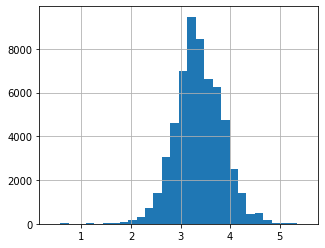

In [24]:
#One can argue this is too much kurtosis though a fairly acceptable level of skew. Let's try and take an exponential attempt and an attempt with normalising y.
Y = np.log1p(data_listings.price_per_guest)
print("Skewness before log transform: ", Y.skew())
print("Kurtosis before log transform: ",Y.kurt())
#Let's visulaise the histogram
Y.hist(bins=30,figsize=(5,4));

In [25]:
#Let's normalise our Y
data_listings.price_per_guest = np.log1p(data_listings.price_per_guest)


### 3f. Factorize boolean variables and identify categorical variables

In [26]:
#data_listings.host_is_superhost.head()

In [27]:
# codes,uniques=data_listings.host_is_superhost.factorize()
# data_listings.host_is_superhost=codes
# data_listings.plot.scatter("host_is_superhost","price2");

In [28]:
#data_listings.host_is_superhost.head()

In [29]:
#data_listings.host_has_profile_pic.head()

In [30]:
# codes,uniques=data_listings.host_has_profile_pic.factorize()
# data_listings.host_has_profile_pic=codes
#data_listings.plot.scatter("number_of_reviews","price2")

In [31]:
# codes,uniques=data_listings.require_guest_profile_picture.factorize()
# data_listings.require_guest_profile_picture=codes
# data_listings.plot.scatter("require_guest_profile_picture","price2");


In [32]:
# codes,uniques=data_listings.instant_bookable.factorize()
# data_listings.instant_bookable=codes
# data_listings.plot.scatter("instant_bookable","price2")

In [33]:
len(data_listings.property_type.unique())

36

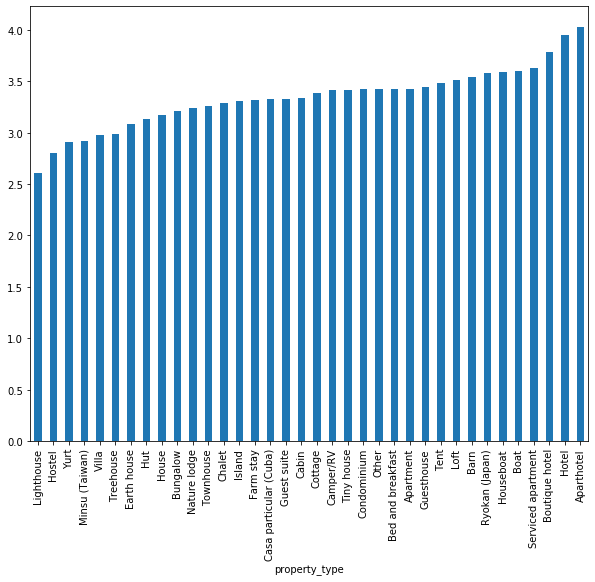

In [34]:
data_listings.groupby('property_type')['price_per_guest'].mean().sort_values().plot.bar(figsize=(10,8));

### 3g. Visualise relationships between numerical variables to ensure no unnecessary variables are retained

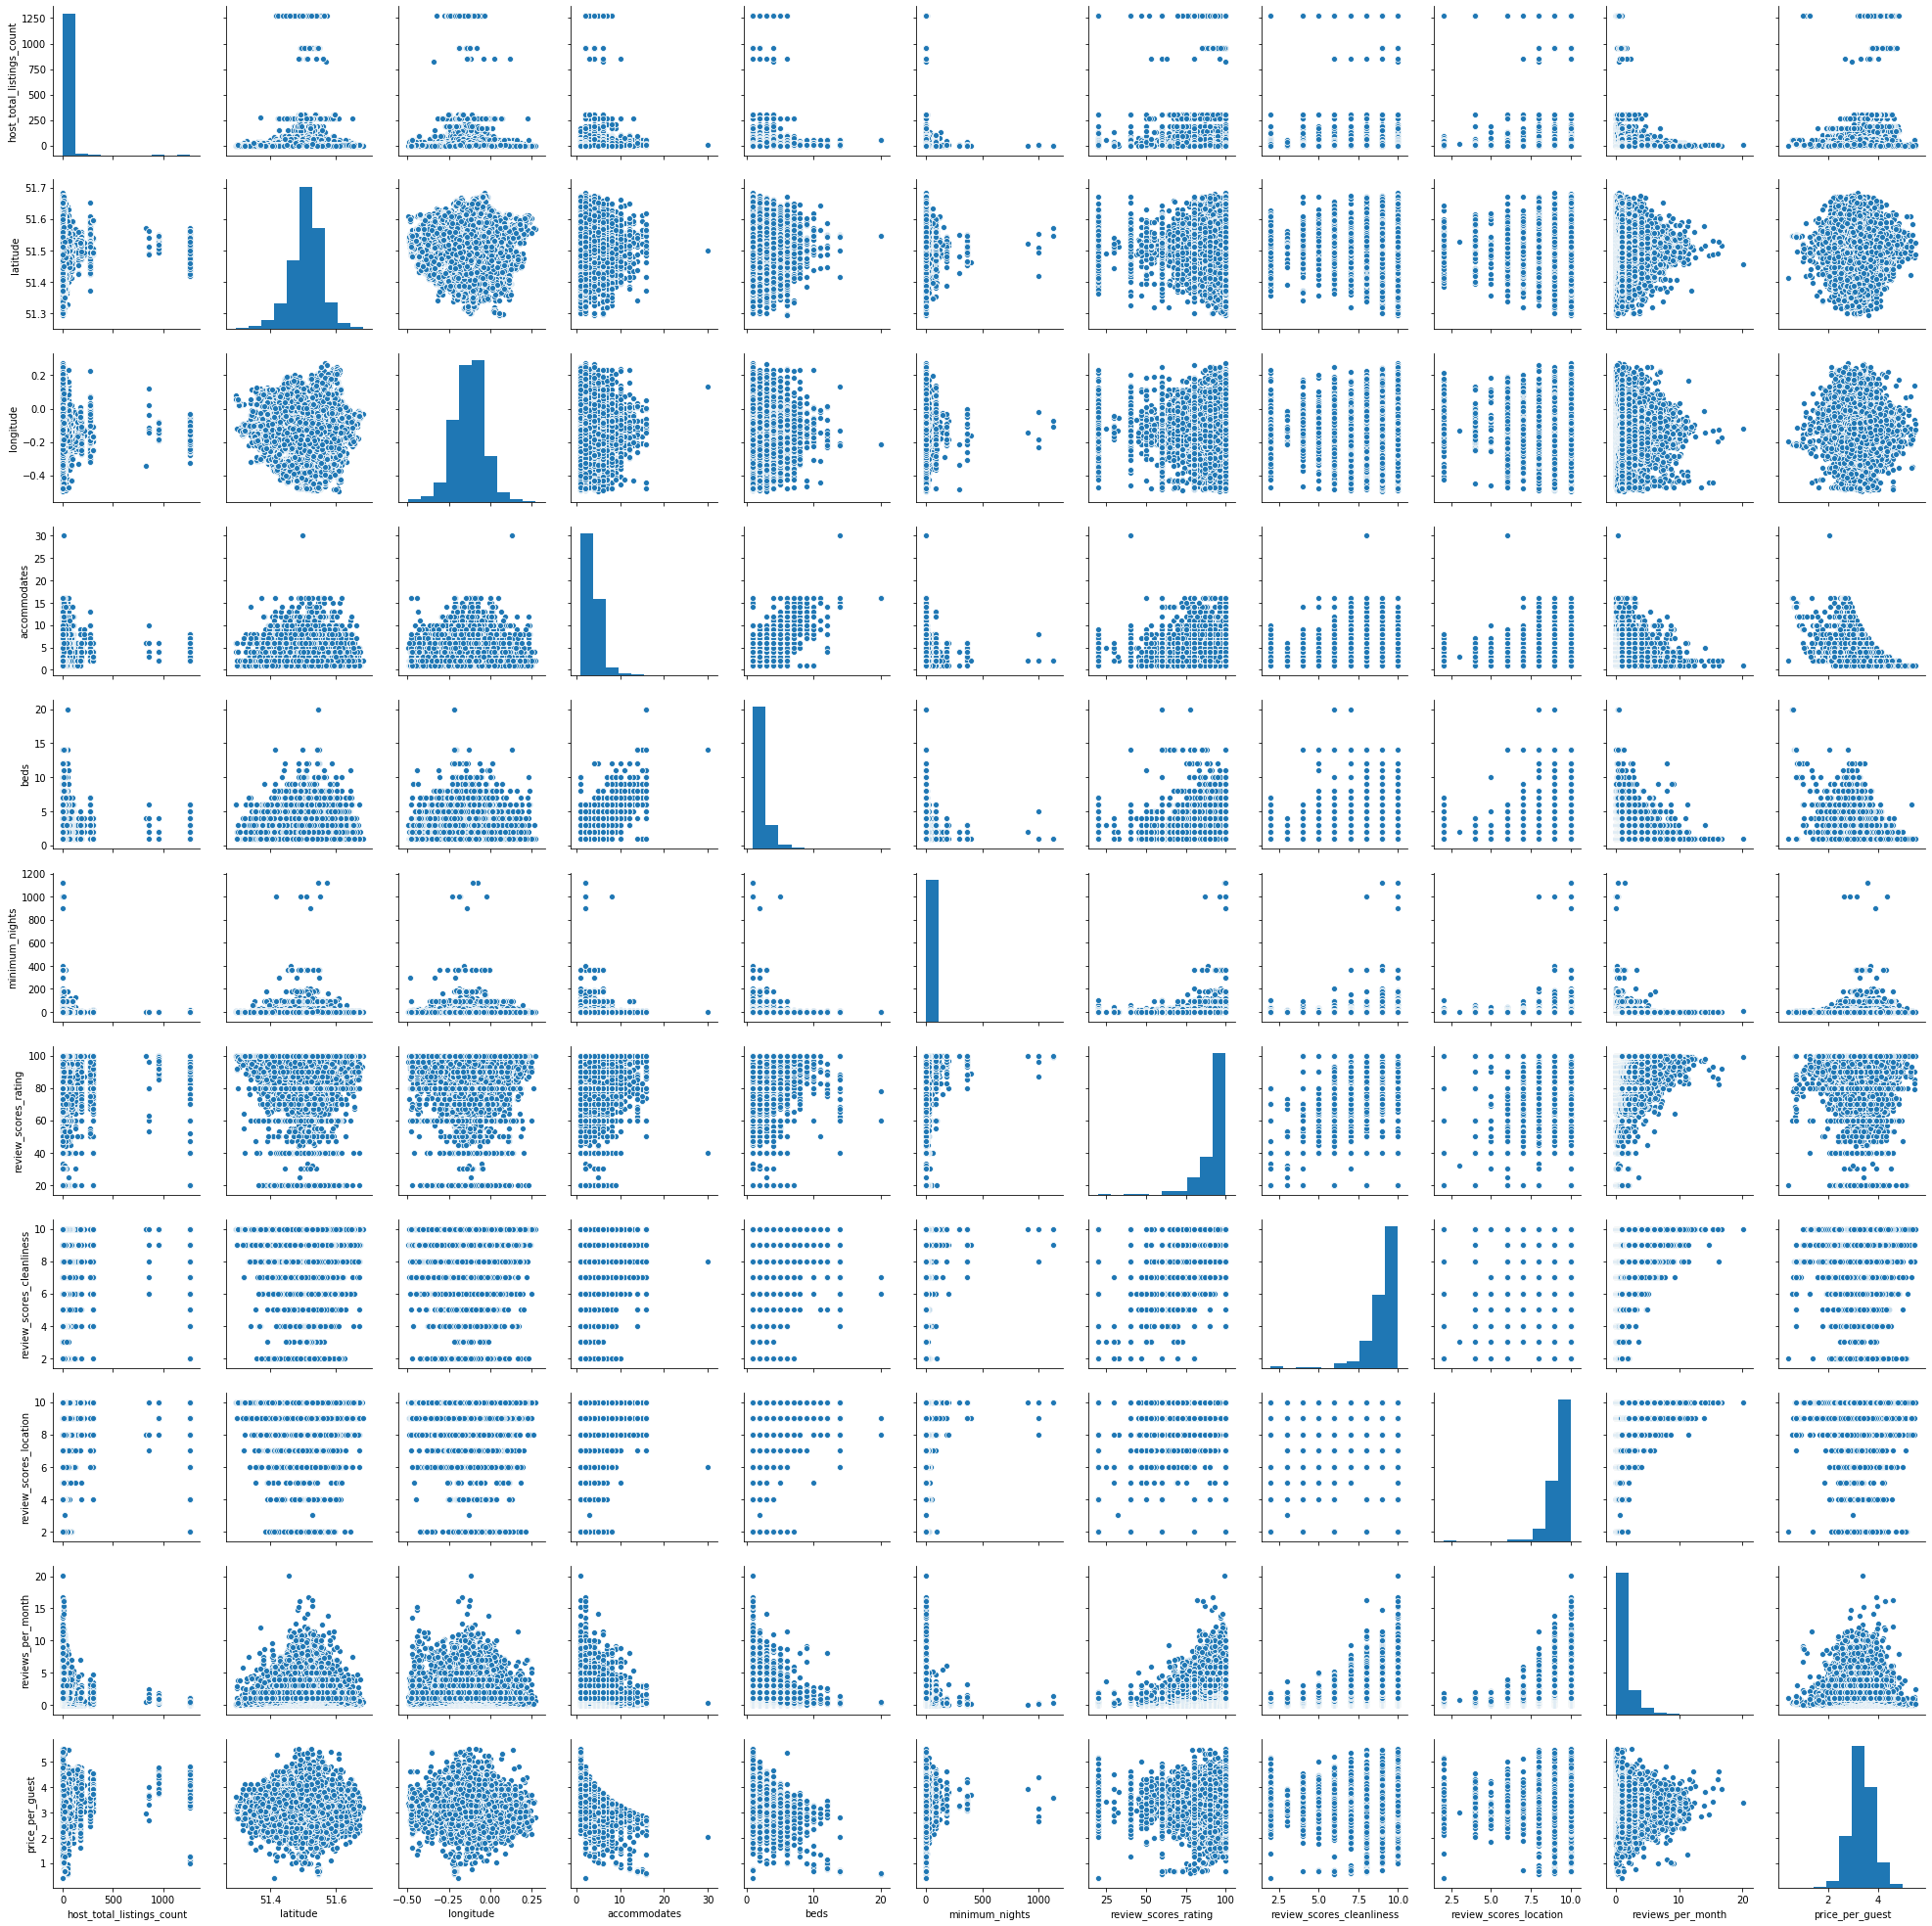

In [35]:
sns.pairplot(data_listings[['host_total_listings_count', 'host_has_profile_pic',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'beds', 'bed_type', 'amenities', 'price',
       'minimum_nights', 'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'reviews_per_month',
       'price_per_guest']])

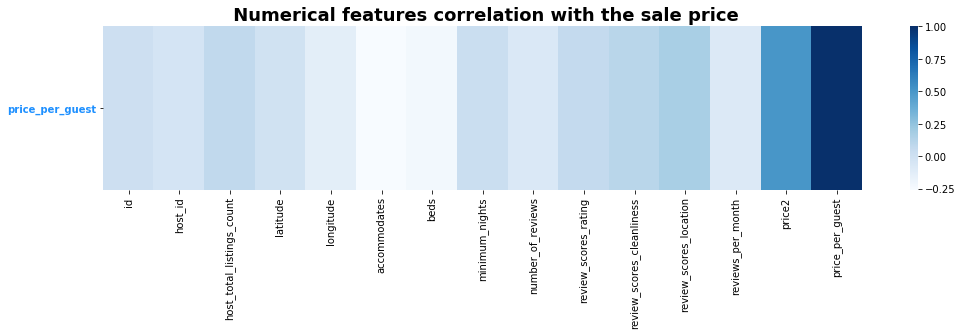

In [36]:
#Let's visualise the correlation between variables
num=data_listings.select_dtypes(exclude='object')
numcorr=num.corr()
f,ax=mpl.pyplot.subplots(figsize=(17,3))
sns.heatmap(numcorr.sort_values(by=['price_per_guest'], ascending=False).head(1), cmap='Blues')
mpl.pyplot.title(" Numerical features correlation with the sale price", weight='bold', fontsize=18)
mpl.pyplot.xticks()
mpl.pyplot.yticks(weight='bold', color='dodgerblue', rotation=0)


mpl.pyplot.show()

In [37]:
numcorr['price_per_guest']

id                           0.014001
host_id                     -0.032055
host_total_listings_count    0.077563
latitude                    -0.009563
longitude                   -0.125550
accommodates                -0.256642
beds                        -0.224139
minimum_nights               0.030289
number_of_reviews           -0.073504
review_scores_rating         0.063914
review_scores_cleanliness    0.109276
review_scores_location       0.172494
reviews_per_month           -0.084599
price2                       0.504386
price_per_guest              1.000000
Name: price_per_guest, dtype: float64

In [38]:
#from the above, we can see little relation between minimum_nights and host_total_listings_count and we can delete them
data_listings.drop(["minimum_nights","host_total_listings_count"],axis=1,inplace=True)

### 3e. Transform neighbourhood and geographical attributes 
#### The latitude and longitude variables reflect a "quadratic relation with price per guest". This in line with our expectation of central London house prices. We will explore this relationship visually and apply a transformation to make it consummable in linear regression.

In [39]:
#zonation data
Zone1=["City of London", "Camden", "Hackney", "Islington", "Kensington and Chelsea", "Southwark", "Westminster"]
Zone2=["Greenwich", "Hackney", "Hammersmith and Fulham", "Lewisham", "Tower Hamlets", "Wandsworth","Lambeth"]
Zone3=["Barnet", "Brent", "Bromley", "Croydon", "Ealing","Hounslow", "Newham", "Richmond upon Thames", "Waltham Forest"]
Zone4=["Barking and Dagenham", "Bexley","Enfield", "Haringey","Merton", "Newham", "Redbridge", "Sutton","Kingston upon Thames"]
Zone5=["Harrow", "Hillingdon","Havering"]


In [40]:
#count=1
zones= [Zone1,Zone2,Zone3,Zone4,Zone5]
mapping=dict()
for bo in data_listings.neighbourhood_cleansed.unique():
    if bo in (Zone1 + Zone2 + Zone3 + Zone4 + Zone5):
        for count,zns in enumerate(zones):
            if bo in zns:
                mapping[bo]="Zone" + str(count+1)
    else:
        print(bo)
            
            

In [41]:
mapping
def zonify(neighbourhood_cleansed):
    return(mapping.get(neighbourhood_cleansed))

In [42]:
data_listings["Fare_Zone_Rough"]=data_listings['neighbourhood_cleansed'].apply(zonify)

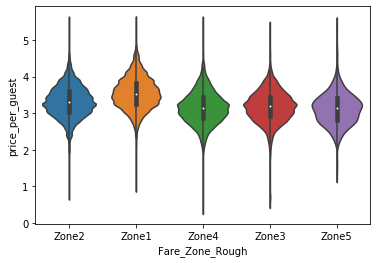

In [43]:
sns.violinplot(x="Fare_Zone_Rough",y="price_per_guest",data=data_listings, figsize=(12,10))

#### We can see that the 50th percentile is higher for more central zones but all have large outliers.

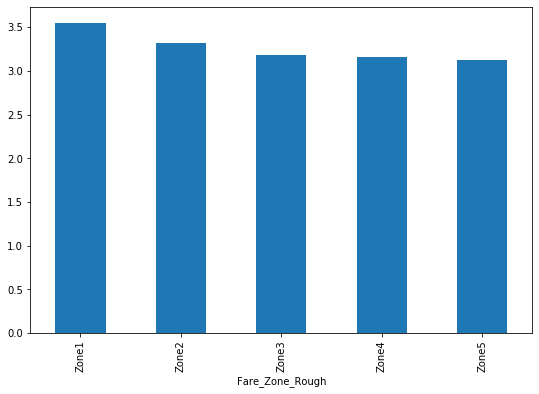

In [44]:
data_listings.groupby('Fare_Zone_Rough')['price_per_guest'].mean().plot.bar(figsize=(9,6));

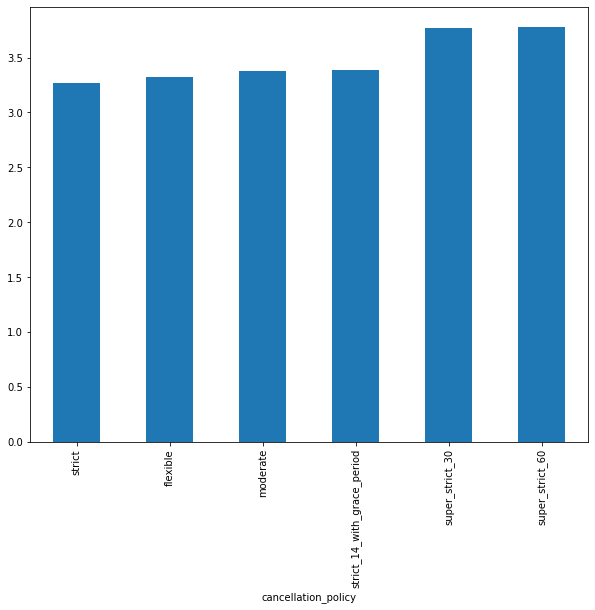

In [45]:
data_listings.groupby("cancellation_policy")["price_per_guest"].mean().sort_values().plot.bar(figsize=(10,8))

#### Let's visualise this against the backdrop of London. A further point of interest would be distance to river characteristic. 

In [46]:
geojson =pd.read_json(data_folder + "neighbourhoods.geojson")

In [47]:
def generateBaseMap(default_location=[51.4975, 0.0007], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [48]:
base_map=generateBaseMap()
base_map

### Explore the density of plots. Let's try to explore the density of listings and their price as a heatmap.
#### As expected they seem to get "cooler" away from the centre.

In [49]:
from folium.plugins import HeatMap
df_copy = data_listings[:1000].copy()
# df_copy['count'] = 1
base_map = generateBaseMap()
HeatMap(data=data_listings[['latitude', 'longitude']][:45001], radius=8, max_zoom=13,blur=0).add_to(base_map);
base_map

In [50]:
data_listings['pppg_prop']=data_listings['price_per_guest']/data_listings.price_per_guest.max()

In [51]:
from folium.plugins import HeatMap
from folium.plugins import Fullscreen
df_copy = data_listings[:1000].copy()
# df_copy['count'] = 1
base_map = generateBaseMap()
HeatMap(data=data_listings[['latitude', 'longitude','pppg_prop']][:45001], radius=8, max_zoom=13,blur=15).add_to(base_map);
base_map
base_map.add_child(folium.ClickForMarker(popup='Potential Location'))
base_map.add_child(Fullscreen(position='topleft', title='Full Screen', title_cancel='Exit Full Screen', force_separate_button=False))


In [52]:
import datetime

In [53]:
time_Df=data_listings[['host_since','latitude', 'longitude','pppg_prop']].sort_values('host_since')
time_Df[:50]
time_Df.host_since=pd.to_datetime(time_Df.host_since)

In [54]:
time_Df[time_Df.host_since.dt.year==2013]
years=time_Df.host_since.dt.year.unique()
heat_data=  [[time_Df[time_Df.host_since.dt.year==year][['latitude','longitude','pppg_prop']]] for year in years]

In [55]:
time_Df[time_Df.host_since.dt.year==2013][['latitude','longitude','pppg_prop']]
heat_data

[[       latitude  longitude  pppg_prop
  62086  51.55416   -0.10358   0.660698
  16896  51.52746   -0.08924   0.721929
  16638  51.52524   -0.08780   0.660698
  60825  51.52559   -0.08840   0.606268
  60833  51.52517   -0.08842   0.635522
  62083  51.52603   -0.08835   0.660698
  70390  51.52664   -0.08916   0.582554
  53463  51.49840   -0.16649   0.621485],
 [       latitude  longitude  pppg_prop
  37408  51.52470   -0.06799   0.553850
  219    51.55518   -0.07673   0.503660
  29045  51.44104   -0.12277   0.582554
  26050  51.44246   -0.12425   0.609415
  64519  51.47073   -0.17520   0.563486
  ...         ...        ...        ...
  5      51.48796   -0.16898   0.711584
  53892  51.47238   -0.14959   0.578898
  74317  51.53866   -0.15460   0.682797
  5721   51.56848   -0.06653   0.783779
  3304   51.51416   -0.01380   0.710695
  
  [123 rows x 3 columns]],
 [       latitude  longitude  pppg_prop
  2869   51.50238   -0.09054   0.711584
  435    51.52115   -0.13970   0.742997
  286   

In [56]:
from folium.plugins import HeatMapWithTime
base_map = generateBaseMap()
HeatMapWithTime(data=heat_data).add_to(base_map)
base_map
#, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True

### Fit a linear model recursively. Then dummify the categorical variables


In [57]:
#Let's dummify some categories e.g Property Type and Rough Fare Zone
data_listings.columns

Index(['id', 'last_scraped', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'access', 'house_rules',
       'host_id', 'host_since', 'host_about', 'host_is_superhost',
       'host_has_profile_pic', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'beds',
       'bed_type', 'amenities', 'price', 'number_of_reviews', 'last_review',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'reviews_per_month', 'price2',
       'price_per_guest', 'Fare_Zone_Rough', 'pppg_prop'],
      dtype='object')

In [58]:
cates=data_listings[['Fare_Zone_Rough','property_type','cancellation_policy']]

In [59]:
data_listings=pd.concat([data_listings,pd.get_dummies(data=cates, drop_first=True)], axis=1)

In [60]:
cates2=data_listings['bed_type']
data_listings=pd.concat([data_listings,pd.get_dummies(data=cates2, drop_first=True)], axis=1)

In [61]:
cates3=data_listings['room_type']
data_listings=pd.concat([data_listings,pd.get_dummies(data=cates3, drop_first=True)], axis=1)

In [62]:
for field in ['require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic']:
    data_listings[field]=data_listings[field].map({'t':(field +' true'),'f':(field +' false')})

In [63]:
data_listings[['require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic']]
cates1=['require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic']
data_listings=pd.concat([data_listings,pd.get_dummies(data=data_listings[cates1], drop_first=True)], axis=1)
data_listings.head()

id last_scraped                                               name  \
0  11551   2019-11-06         Arty and Bright London Apartment in Zone 2   
3  38407   2019-11-06                  Canary Wharf Immaculate Apt for 2   
4  90700   2019-11-06                  Sunny Notting Hill flat & terrace   
5  15400   2019-11-06                Bright Chelsea  Apartment. Chelsea!   
6  92399   2019-11-06  MODERN SELF CONTAINED ARCHITECT FLATLET, ISLIN...   

                                             summary  \
0  Unlike most rental apartments out there my fla...   
3  The bright, light and stylish apartment in Can...   
4  This is a home not a hotel - for the cost gues...   
5  Lots of windows and light.  St Luke's Gardens ...   
6  FULLY SELF CONTAINED. A  newly renovated, self...   

                                               space  \
0  Amenities Bedding: 1 Double bed, 1 living room...   
3  An entire bright, light and stylish apartment....   
4  This charming 1 bedroom with en-suite bathroom...   
5  Bright Chelsea Apartment  This is a bright one...   
6  Highly convenient, centrally located and newly...   

                                         description experiences_offered  \
0  Unlike most rental apartments out there my fla...              family   
3  The bright, light and stylish apartment in Can...                none   
4  This is a home not a hotel - for the cost gues...                none   
5  Lots of windows and light.  St Luke's Gardens ...            romantic   
6  FULLY SELF CONTAINED. A  newly renovated, self...            business   

                               neighborhood_overview  \
0  Not even 10 minutes by metro from Victoria Sta...   
3  Very easy to get to all the main sites. The tu...   
4  A quick guide or a run through about the area ...   
5                                     It is Chelsea.   
6  Newington Green is a wonderful little pocket o...   

                                              access  \
0     Guest will have access to the entire apartment   
3  This is a quiet self-contained apartment with ...   
4        The whole place is for our guests to enjoy.   
5  There are two wardrobes for guests exclusive u...   
6  Guest have access to their own space and separ...   

                                         house_rules  host_id  host_since  \
0  No Smoking (very strict) No pets are allowed i...    43039  2009-10-03   
3         Respect both check-in and check-out times.   164566  2010-07-12   
4  Full rules will be provided on arrival but the...   491286  2011-04-07   
5  NO SMOKING PLEASE.. No unauthorised guests. No...    60302  2009-12-05   
6  HOUSE RULES: For those who are new to Airbnb, ...   497366  2011-04-10   

                                          host_about        host_is_superhost  \
0  Hello, I'm a friendly Italian man with a very ...   host_is_superhost true   
3  A entire bright, light and stylish apartment. ...  host_is_superhost false   
4  I am a curator working for a gallery in Mayfai...  host_is_superhost false   
5  English, grandmother,  I have travelled quite ...  host_is_superhost false   
6  We are Architects, working and living in Londo...   host_is_superhost true   

        host_has_profile_pic  neighbourhood_cleansed  latitude  longitude  \
0  host_has_profile_pic true                 Lambeth  51.46225   -0.11732   
3  host_has_profile_pic true           Tower Hamlets  51.49995   -0.02624   
4  host_has_profile_pic true  Kensington and Chelsea  51.51074   -0.19853   
5  host_has_profile_pic true  Kensington and Chelsea  51.48796   -0.16898   
6  host_has_profile_pic true               Islington  51.55071   -0.08547   

  property_type        room_type  accommodates  beds  bed_type  \
0     Apartment  Entire home/apt             4   1.0  Real Bed   
3     Apartment  Entire home/apt             2   1.0  Real Bed   
4         House  Entire home/apt             2   1.0  Real Bed   
5     Apartment  Entire home/apt             2   1.0  Real Bed   
6

In [64]:
pd.set_option('display.max_columns', None)

In [65]:
data_listings.drop(['Fare_Zone_Rough','property_type','cancellation_policy'],axis=1,inplace=True)

In [66]:
data_listings.drop(['require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic'],axis=1,inplace=True)

In [67]:
data_listings.dropna(inplace=True)

In [68]:
data_listings.groupby('room_type')['price_per_guest'].mean()

room_type
Entire home/apt    3.451307
Hotel room         3.663682
Private room       3.233315
Shared room        2.760778
Name: price_per_guest, dtype: float64

In [81]:
X=data_listings[['beds','number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Apartment',
       'property_type_Barn', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Casa particular (Cuba)',
       'property_type_Chalet', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Earth house',
       'property_type_Farm stay', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Houseboat',
       'property_type_Hut', 'property_type_Island', 'property_type_Lighthouse',
       'property_type_Loft', 'property_type_Minsu (Taiwan)',
       'property_type_Nature lodge', 'property_type_Other',
       'property_type_Ryokan (Japan)', 'property_type_Serviced apartment',
       'property_type_Tent', 'property_type_Tiny house',
       'property_type_Townhouse', 'property_type_Treehouse',
       'property_type_Villa', 'property_type_Yurt',
       'require_guest_profile_picture_require_guest_profile_picture true',
       'instant_bookable_instant_bookable true',
       'host_is_superhost_host_is_superhost true',
       'host_has_profile_pic_host_has_profile_pic true','Couch', 'Futon',
       'Pull-out Sofa', 'Real Bed','Hotel room', 'Private room',
       'Shared room']]

In [82]:
#split the data into simple train_test_split
Y=data_listings.price_per_guest
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

In [83]:
#Let's just impress a simple linear model on my feature set
from sklearn.linear_model import LinearRegression
linreg_fa=LinearRegression()

In [84]:
#data_listings[numeric_fields].isna().sum()
X.isna().sum()
#X.dropna(inplace=True)
X.isna().sum()
print(X.shape,Y.shape)

(16141, 55) (16141,)


In [85]:
#linreg_fa.fit(data_listings[numeric_fields],data_listings.price_per_guest)
linreg_fa.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [86]:
# for item in numeric_fields:
#     sns.lmplot(x=item, y="price_per_guest", data=data_listings,col="Fare_Zone_Rough", aspect=1.5, scatter_kws={'alpha':0.2},hue="property_type");

In [87]:
#price_pred=linreg_fa.predict(data_listings[numeric_fields])
price_pred=linreg_fa.predict(X_train)


In [88]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_train, price_pred)
rmse = np.sqrt(mse)

print('Mean squared error: %f'% mse)
print('Root mean squared error: %f'% rmse)

Mean squared error: 0.159713
Root mean squared error: 0.399641


In [89]:
#Fit on test set
from sklearn.metrics import r2_score
print("Testing set RMSE: {:.2f}".format(np.sqrt(mean_squared_error(Y_test, linreg_fa.predict(X_test)))))
print("Training set RSquared: {:.2f}".format(r2_score(Y_train, price_pred)))
print("Testing set RSquared: {:.2f}".format(r2_score(Y_test, linreg_fa.predict(X_test))))


Testing set RMSE: 0.40
Training set RSquared: 0.27
Testing set RSquared: 0.26


In [78]:
from sklearn.utils.multiclass import type_of_target
type_of_target(Y)

'continuous'

In [90]:
#Try RFE
%timeit
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.svm import SVR
estimator = SVR(kernel="linear")
#selector = RFECV(estimator, step=1)
#selector = selector.fit(X, Y)


#from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator, step=2)
rfecv.fit(X_train,Y_train)


print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores


C:\Users\isimr\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Optimal number of features : 55


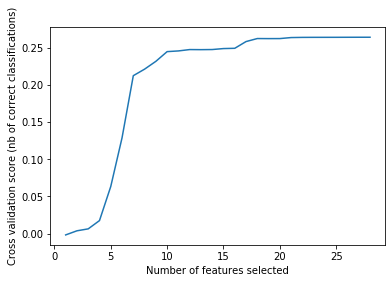

In [93]:
mpl.pyplot.figure()
mpl.pyplot.xlabel("Number of features selected")
mpl.pyplot.ylabel("Cross validation score (nb of correct classifications)")
mpl.pyplot.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
mpl.pyplot.show()

In [101]:
X_train.columns.shape

(55,)

In [100]:
rfecv.support_
rfecv.grid_scores_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [145]:
X.shape

(16141, 17)

In [103]:
#try ols
import statsmodels.api as sm

X = sm.add_constant(X_train)
model = sm.OLS(Y_train, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_guest   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     102.1
Date:                Sun, 23 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:46:32   Log-Likelihood:                -6478.6
No. Observations:               12912   AIC:                         1.305e+04
Df Residuals:                   12864   BIC:                         1.341e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
const                                                                2.9023      0.293      9.898      0.000       2.328       3.477
beds                                                                -0.1404      0.004    -39.474      0.000      -0.147      -0.133
number_of_reviews                                                -6.223e-05   8.71e-05     -0.714      0.475      -0.000       0.000
review_scores_rating                                                -0.0034      0.001     -4.952      0.000      -0.005      -0.002
review_scores_cleanliness                                            0.0452      0.006      8.020      0.000       0.034       0.056
review_scores_location                                               0.1112      0.006     19.332      0.000       0.100       0.123
reviews_per_month                                                   -0.0315      0.004     -9.009      0.000      -0.038      -0.025
Fare_Zone_Rough_Zone3                                               -0.1661      0.011    -14.814      0.000      -0.188      -0.144
Fare_Zone_Rough_Zone4                                               -0.1888      0.013    -14.798      0.000      -0.214      -0.164
Fare_Zone_Rough_Zone5                                               -0.2365      0.031     -7.610      0.000      -0.297      -0.176
property_type_Apartment                                             -0.2416      0.203     -1.190      0.234      -0.640       0.156
property_type_Barn                                                2.698e-15    4.2e-15      0.642      0.521   -5.54e-15    1.09e-14
property_type_Bed and breakfast                                     -0.1203      0.205     -0.587      0.557      -0.522       0.281
property_type_Boat                                                  -0.1407      0.229     -0.613      0.540      -0.591       0.309
property_type_Boutique hotel                                         0.0164      0.242      0.068      0.946      -0.459       0.492
property_type_Bungalow                                              -0.2963      0.218     -1.361      0.174      -0.723       0.131
property_type_Cabin                                                 -0.4515      0.261     -1.732      0.083      -0.962       0.059
property_type_Camper/RV                                             -0.9281      0.348     -2.663      0.008      -1.611      -0.245
property_type_Casa particular (Cuba)                               1.89e-15   6.97e-16      2.710      0.007    5.23e-16    3.26e-15
property_type_Chalet                                                -0.1911      0.308     -0.621      0.535      -0.794       0.412
property_type_Condominiu

In [104]:
#remove property type barn, property type bed and breakfast, property_type_boat, property type boutique hotesl ,property_type apartment,propoerty type bungalow,propoerty type cabin, property type camper,propoerty type casa, porperty tyep chalet,
#remove porperty condo, property type cottage, porperty type earth, propoerty type farm stay, propoerty type guest suite, property type guest house, propoerty type hotel, propoerty type house, property type house boat, hut, island
#lighthouse, loft, minsu.nature lodge, other ryokan, service apartment, propoerty type tent, propoerty tiny house
#real bed, pull out sodfa, futon, couch, host profile pic, requires guest profile, yurt,villa

In [105]:
#updated X, fit with scaled and lassor data

In [106]:
X=data_listings[['beds','number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Camper/RV', 'property_type_Casa particular (Cuba)',
       'property_type_Hostel','instant_bookable_instant_bookable true',
       'host_is_superhost_host_is_superhost true','Hotel room', 'Private room',
       'Shared room']]

In [108]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_s=scaler.fit_transform(X)


In [109]:
X_train, X_test, Y_train, Y_test = train_test_split(X_s, Y, test_size = .20, random_state = 40)

In [110]:
linreg_sa=LinearRegression()
linreg_sa.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [111]:
price_pred_scaled=linreg_sa.predict(X_train)
mse_scaled = mean_squared_error(Y_train, price_pred_scaled)
rmse_scaled = np.sqrt(mse)

print('Mean squared error: %f'% mse)
print('Root mean squared error: %f'% rmse)

Mean squared error: 0.159713
Root mean squared error: 0.399641


In [115]:
r2_score(Y_test,linreg_sa.predict(X_test))

0.2560174191099144

In [116]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV


In [121]:
model_lasso = Lasso(normalize=True, alpha=0.00001)
model_lasso.fit(X_train, Y_train)
model_lasso.coef_

array([-0.16225897, -0.0014843 , -0.02334381,  0.03899072,  0.07684052,
       -0.04251284, -0.05433193, -0.05423476, -0.02579322, -0.00666675,
        0.        , -0.01083836, -0.01782768,  0.02770061,  0.02314502,
       -0.15600665, -0.03181151])

In [122]:
from sklearn.exceptions import ConvergenceWarning
from  warnings import simplefilter
simplefilter("ignore", category=ConvergenceWarning)

In [123]:
gs = GridSearchCV(estimator=Lasso(normalize=True),
                  param_grid={'alpha': np.logspace(-10, 10, 20)},
                  scoring='neg_mean_squared_error',
                  cv=5)

gs.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=True, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-10, 1.12883789e-09, 1.27427499e-08, 1.43844989e-07,
       1.62377674e-06, 1.83298071e-05, 2.06913808e-04, 2.33572147e-03,
       2.63665090e-02, 2.97635144e-01, 3.35981829e+00, 3.79269019e+01,
       4.28133240e+02, 4.83293024e+03, 5.45559478e+04, 6.15848211e+05,
       6.95192796e+06, 7.84759970e+07, 8.85866790e+08, 1.00000000e+10])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [124]:
gs.best_estimator_

Lasso(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

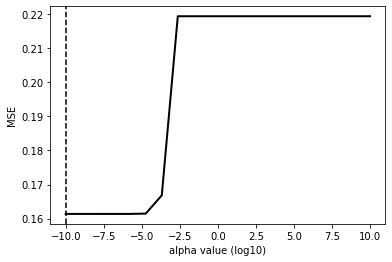

In [125]:
nlog_alphas = np.log10(gs.param_grid['alpha'])
mean_mses = [-x for x in gs.cv_results_['mean_test_score']]
mpl.pyplot.figure()
mpl.pyplot.plot(nlog_alphas, mean_mses, linewidth=2, color='k')
mpl.pyplot.axvline(np.log10(gs.best_params_['alpha']), linestyle='--', color='k')
mpl.pyplot.xlabel('alpha value (log10)')
mpl.pyplot.ylabel('MSE')
mpl.pyplot.show()

In [129]:
nlog_alphas

array([-10.        ,  -8.94736842,  -7.89473684,  -6.84210526,
        -5.78947368,  -4.73684211,  -3.68421053,  -2.63157895,
        -1.57894737,  -0.52631579,   0.52631579,   1.57894737,
         2.63157895,   3.68421053,   4.73684211,   5.78947368,
         6.84210526,   7.89473684,   8.94736842,  10.        ])

In [130]:
10**-5.78947368
## This is the lowest MSE from the optimal alpha LAsso

1.6237767549313904e-06

In [131]:
#Try Elastic Net and Recursive search
from sklearn.linear_model import ElasticNetCV

In [138]:
regr = ElasticNetCV(cv=5, random_state=0)
regr.fit(X_train, Y_train)
ElasticNetCV(cv=5, random_state=0)
print(regr.alpha_)
print(regr.coef_)


0.00021587460098629154
[-0.16346611 -0.00240773 -0.02793264  0.04235759  0.07834621 -0.04317864
 -0.05530692 -0.05517906 -0.02681007 -0.00758209  0.         -0.01206629
 -0.01885089  0.02932654  0.02424379 -0.1569068  -0.0325656 ]


In [134]:
data_listings[['beds','number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Camper/RV',
       'property_type_Hostel','instant_bookable_instant_bookable true',
       'host_is_superhost_host_is_superhost true','Hotel room', 'Private room',
       'Shared room']]


AttributeError: 'Lasso' object has no attribute 'support_'

In [ ]:
SVM_predict =selector.predict(data_listings[numeric_fields])
selector.score(data_listings[numeric_fields],data_listings.price_per_guest)

In [ ]:
#let's add the categorical features
#train-test split
data_listings1.columns

In [ ]:
categorical=['host_has_profile_pic','host_total_listings_count','host_is_superhost','property_type','room_type','instant_bookable','require_guest_profile_picture']

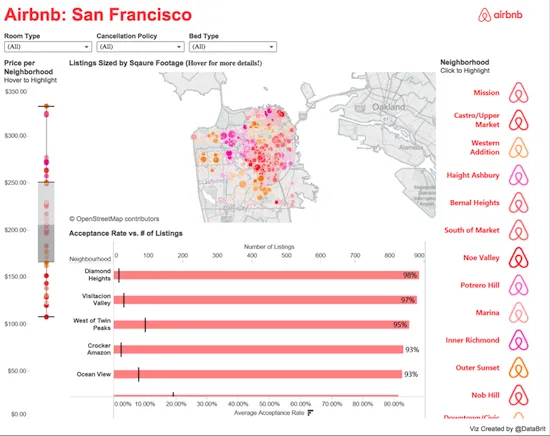

In [ ]:
#north vs south
#distance to the river characteristic
#abs differnce to longitude
#abs diference to lat

In [ ]:
data_listings[text_fields].amenities

In [146]:
%store -r rfreg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=780,
                      n_jobs=None, oob_score=False, random_state=22, verbose=0,
                      warm_start=False)

In [449]:
import requests
import urllib
import re
from bs4 import BeautifulSoup

In [452]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [450]:
url_ex='https://www.airbnb.co.uk/rooms/13537972?source_impression_id=p3_1582656651_%2BPFfWYhOAFxQgru5&guests=1&adults=1&check_in=2020-04-29&check_out=2020-04-30'
example1= requests.get(url_ex)
soup =BeautifulSoup(example1.content,'html.parser')

In [453]:
name=(soup.find(id='summary').find('span',class_= '_18hrqvin')).text
listing_info = (soup.find_all(class_='_36rlri',style="margin-right:24px"))
guests=int(listing_info[0].text.split(" guests")[0])
property_type=listing_info[1]
beds_no = int(listing_info[2].text.split(" beds")[0])
#superhost - default is 1
summary_listing=soup.find(id='details').find('span',class_= '_czm8crp').text
review_score_overall=float(soup.find(id='reviews').find('div',class_= '_1iv05u9z').text[:4])
review_score_loc=float((soup.find(id='reviews').find_all(class_='_1p3joamp'))[0].text)
review_score_clean=float((soup.find(id='reviews').find_all(class_='_1p3joamp'))[4].text)
zone_dummy=mapping.get('Barnet')
neighbourhood_ov=str(input())


vvl


In [532]:
review_no= soup.find(id='reviews').find('span',class_= '_krjbj').text[:4]
review_no

'542 '

In [454]:
selector=widgets.SelectMultiple(
    options=['First aid kit','Fire extinguisher','Wifi', 'Dryer', 'Smoke Detector','Essentials','Heating','Iron','TV','Washing Machine','Kitchen','Hair dryer','Hangers','Carbon monoxide alarm','Air conditioning','Private entrance','shampoo'],
    value=['Wifi'],
    rows=15,
    description='Fruits',
    disabled=False
)
display(selector)

SelectMultiple(description='Fruits', index=(2,), options=('First aid kit', 'Fire extinguisher', 'Wifi', 'Dryer…

In [455]:
amenities= set()
amenities.add(selector.value)

In [520]:
url_Ex2='https://www.airbnb.co.uk/rooms/4168785?previous_page_section_name=1000&search_id=de0a987e-ad1d-7e13-5c4c-b7ccf0e2098a&federated_search_id=981ed21a-975c-48a0-af0e-f83b140d7f88'

In [533]:
example1= requests.get(url_Ex2)
soup =BeautifulSoup(example1.content,'html.parser')
name=(soup.find(id='summary').find('span',class_= '_18hrqvin')).text
listing_info = (soup.find_all(class_='_36rlri',style="margin-right:24px"))
guests=int(listing_info[0].text.split(" guests")[0])
property_type=listing_info[1].text.split(" beds")[0]
beds_no = int(listing_info[2].text.split(" bed")[0])
#superhost - default is 1
summary_listing=soup.find(id='details').find('span',class_= '_czm8crp').text
review_score_overall=float(soup.find(id='reviews').find('div',class_= '_1iv05u9z').text[:4])
review_score_loc=float((soup.find(id='reviews').find_all(class_='_1p3joamp'))[0].text)
review_score_clean=float((soup.find(id='reviews').find_all(class_='_1p3joamp'))[4].text)
zone_dummy=mapping.get(input('Borough'))
neighbourhood_ov=str(input())


BoroughCamden
ff


In [522]:
print("Name: "+name)
print("Guests: "+str(guests))
print("Property Type: "+ str(property_type))
print("Beds No: " + str(beds_no))
print(summary_listing[:150])
print(review_score_overall)
print(review_score_loc)
print(review_score_clean)


Name: Regents park double room. The best.
Guests: 3
Property Type: 1 bedroom
Beds No: 1
The comfy double bed room a minute from Regent's Park. The amazing location and quiet neighbourhood. Please read the room description for more info.
4.61
4.8
4.7


In [517]:
display(selector)

SelectMultiple(description='Fruits', index=(7, 8, 9, 10, 11, 12, 15), options=('First aid kit', 'Fire extingui…

In [518]:
amenities= set()
amenities.add(selector.value)

In [534]:
zone_dummy

'Zone1'

In [447]:
#combine all

In [536]:
fieldsa={'beds', 'number_of_reviews','review_scores_rating','review_scores_cleanliness','review_scores_location',
"require_guest_profile_picture_require_guest_profile_picture true", 'instant_bookable_instant_bookable true','host_is_superhost_host_is_superhost true', 'host_has_profile_pic_host_has_profile_pic true',
'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Apartment',
       'property_type_Barn', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Earth house', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Houseboat',
       'property_type_Hut', 'property_type_Lighthouse',
       'property_type_Loft', 'property_type_Other',
        'property_type_Serviced apartment', 'property_type_Tiny house', 'property_type_Treehouse',
       'property_type_Villa',
 'room_type_Private room',
       'room_type_Shared room'}

In [537]:
new_input={}
for col in fieldsa:
    new_input[col]=np.nan

In [540]:
def update_new_input(new_input):
    new_input['beds']=beds_no
    new_input['number_of_reviews']=review_no
    new_input['review_scores_rating']=review_score_overall  
    new_input['review_scores_cleanliness']:review_score_clean
    new_input["require_guest_profile_picture_require_guest_profile_picture true"]=1
    new_input['instant_bookable_instant_bookable true']=1
    new_input['host_is_superhost_host_is_superhost true']=0
    new_input['host_has_profile_pic_host_has_profile_pic true']=1,
    new_input['name']=name
    new_input['amenities']=amenities
    new_input['summary']=summary_listing
    new_input['review_scores_location']=review_score_loc
    

SyntaxError: invalid syntax (<ipython-input-540-88be60d6e731>, line 5)

In [ ]:
#Update as needed using these
property_type=listing_info[1].text.split(" beds")[0]
zone_dummy=mapping.get(input('Borough'))
neighbourhood_ov=str(input())
new_input['neighborhood_overview']=neighbourhood_ov    
text_string= name+ " " + " summary" +" " + amenities + " "+ neighbourhood_ov
new_input['text_all']=text_string

In [539]:
X_test.append(new_input,ignore_index=True)

(3229, 17)

In [544]:
2+2
%alias_magic t timeit

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [548]:
%timeit 2+2

16.3 ns ± 4.73 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
